# K-Means with Cluster Merging and Density

## Table of contents
1. [Helper functions and imports](#helperfunctions)
2. [K-Means with Cluster Merging and Density Code](#kmeanscdcode)
3. [Main Concept](#mainconcept)
4. [Clearly Separable Datasets](#clearlyseparabledatasets)
5. [Density and Overlap](#densityandoverlap)

## 1. Helper functions and imports <a name="helperfunctions"></a>

### Imports

In [2]:
# k-means
from sklearn.cluster import KMeans

# data set creators
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

# numpy
import numpy as np

# pyplot
from matplotlib import pyplot as plt

# distance matrix
from sklearn.metrics import pairwise_distances

# volume of n-ball
import math

# 3D plots
from mpl_toolkits.mplot3d import Axes3D

### Helper functions for plotting

In [4]:
# A function to make plotting easy
# to plot an unlabeled dataset X use np.zeros(X.shape[0]) as labels
# Adjusted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

def plot_clustering(X, labels, outliers=-1):
    """
    Plots the clustering in color for 2 dimensional data sets.
    Taken from an example on the scikit-learn homepage and 
    adjusted. Reference above. License from scikit-learn applies
    """
    # square to not disturb visual accuracy
    plt.figure(figsize=(10,10))

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == outliers:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8)   
    plt.show()

In [5]:
# A function to make plotting easy with circles
# to plot an unlabeled dataset X use np.zeros(X.shape[0]) as labels
# Adjusted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

def plot_clustering_with_circles(X, labels, cluster_centers, radii, outliers=-1, only_circles=False):
    """
    Plots the clustering in color for 2 dimensional data sets.
    Taken from an example on the scikit-learn homepage and 
    adjusted. Reference above. License from scikit-learn applies
    """
    # square to not disturb visual accuracy
    plt.figure(figsize=(10,10))

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
    ecolor = "k"

    alpha=1
    if only_circles == True:
        alpha=0

    
    for k, col in zip(unique_labels, colors):
        if k == outliers:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=ecolor, markersize=8, alpha=alpha)       
    
    # Plot circles
    for i in range(cluster_centers.shape[0]):
        circle = plt.Circle(cluster_centers[i], radii[0, i], color='black', fill=False)
        plt.gca().add_patch(circle)
    
    plt.show()

In [6]:
# 3D Plotting
def plot_clustering_3d(X, labels):

    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
        for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)

        xy = X[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', s=100, edgecolor='k')

    plt.show()

### helper functions for labels

In [10]:
def unify_labels(labels1, labels2, labels1_outlier=-1, labels2_outlier=-1):
    
    """
    Unifies two labelings for the same data set
    """
    assert labels1.shape == labels2.shape, "Labels' shapes differ!"
    initial_num_labels2 = len(set(labels2))
    labels_unified = labels2.copy()
    if labels2_outlier != labels1_outlier: # switch outlier labels if needed
        labels_unified[np.where(labels2 == labels2_outlier)] = labels1_outlier 
    labels1_unique = np.array(list(set(labels1)))
    labels2_unique = np.array(list(set(labels2)))
    adjacency_matrix = np.zeros((labels1_unique.shape[0], labels2_unique.shape[0]))
    for i in range(labels1_unique.shape[0]):
        for j in range(labels2_unique.shape[0]):
            if labels1_unique[i] == labels1_outlier or labels2_unique[j] == labels2_outlier:
                adjacency_matrix[i,j] = 0 # outliers will not be synced by this mechanism
            else:
                indices_labels1 = set(np.where(labels1 == labels1_unique[i])[0])
                indices_labels2 = set(np.where(labels2 == labels2_unique[j])[0])
                len_labels1 = len(indices_labels1)
                len_labels2 = len(indices_labels2)
                len_intersection = len(indices_labels1.intersection(indices_labels2)) 
                adjacency_matrix[i,j] =  (2*len_intersection)/(len_labels1 + len_labels2)
    while np.max(adjacency_matrix) > 0: # This will not work for outlier identifiers >0
        max_value = np.max(adjacency_matrix)
        row_idx = np.where(adjacency_matrix == max_value)[0][0]
        col_idx = np.where(adjacency_matrix == max_value)[1][0]
        if labels1_unique[row_idx] in set(labels_unified): # make sure we do not overwrite labels
            labels_unified[(np.where(labels_unified == labels1_unique[row_idx]))] = max(set(labels_unified))+1
        labels_unified[np.where(labels2 == labels2_unique[col_idx])] = labels1_unique[row_idx]
        adjacency_matrix[row_idx, :]=0
        adjacency_matrix[:, col_idx]=0
    assert initial_num_labels2 == len(set(labels_unified)), "Labels are missing!"
    return labels_unified  

### helper function to find stable clusters

In [161]:
def cluster_formation_matrix(X, k_list, minPts=0):
    
    """
    Creates a table with several runs for the same or different k so check for stable clusters
    """
    k_runs = []
    for i in range(len(k_list)):
        k_runs.append(KMeans(n_clusters=k_list[i]).fit(X))
    labels_runs=np.zeros((X.shape[0], len(k_list)))
    for i in range(len(k_list)):
        labels_runs[:,i] = KMeansCD(k_runs[i], X, minPts=minPts).fit().labels_
    labels_count=[]
    for i in range(len(k_list)):
        labels_count.append(len(set(labels_runs[:,i])))
    max_clusters=max(labels_count)
    max_clusters_index = labels_count.index(max_clusters)
    labels_runs_norm=np.zeros((X.shape[0], len(k_list)))
    
    labels_runs_norm[:, max_clusters_index]=labels_runs[:, max_clusters_index]
    iterrange = list(range(len(k_list)))
    iterrange.remove(max_clusters_index)
    for i in iterrange:
        labels_runs_norm[:, i]=unify_labels(labels_runs[:, max_clusters_index], labels_runs[:, i])
    labelscount_klist = np.zeros((max_clusters+1, labels_runs.shape[1]))
    for k in range(len(k_list)):
        labelscount_klist[0, k] = k_list[k]
    i=1
    for label in set(labels_runs_norm[:, max_clusters_index]):
        for j in range(labels_runs_norm.shape[1]):
            labelscount_klist[i, j] = sum(labels_runs_norm[:,j]==label)
        i+=1
    np.set_printoptions(suppress=True)
    outliers = True if -1 in labels_runs[:, max_clusters_index] else False
    print("First row: k-values.")
    if outliers:
        print("Last row outliers.")
    print(F"Labels compared with cluster {max_clusters_index+1}.")
    print("Missing small numbers could not be fit with this clusterings' clusters.")
    print(labelscount_klist)

## 2. K-Means with Cluster Merging and Density Code <a name="kmeanscdcode"></a>

In [69]:
class KMeansCD:
    
    """
    Takes a fitted k-means object and data as input. 
    Creates new clustering depending on the input parameters via the fit() method
    
    self.labels_: the new labels
    self.ppr_: points per radius. Can be used to estimate minPts for density case
    self.radius_matrix_: for debugging and understanding
    self.adjacency_matrix_: for debugging and understanding
    self.connected_subgraphs_: for debugging and understanding
    
    """
    
    def __init__(self, kmeans, data, minPts=1):
        self.kmeans = kmeans
        self.data = data
        self.minPts = minPts
        
    def create_radius_vector(self, X, cluster_centers, labels):
        """
        Creates the radius vector
        """
        r = np.zeros((1, cluster_centers.shape[0]))
        for i in range(r.shape[1]):
            p = X[labels == i]
            c = cluster_centers[i]
            d = np.zeros((1, p.shape[0]))
            for j in range(p.shape[0]):
                d[0,j]=np.sqrt(((p[j]-c)@(p[j]-c).T))
            r[0, i]=np.max(d)
        return r

    def create_adjacency_matrix_cluster_centers_w_density(self, old_labels, cluster_centers, radii, minPts):
        """
        Creates the adjacency matrix for the cluster center by creating:
        * a distance matrix
        * a radius matrix
        * distance matrix
        * where this is > 0 put a "1", else a "0"
        """
        dist_matrix = pairwise_distances(cluster_centers)
        radius_matrix = radii + radii.T
        adjacency_matrix = ((radius_matrix - dist_matrix) > 0)*1
        mean_radius = np.mean(radius_matrix)
        dimension = cluster_centers.shape[1]
    
        # drop the rows for cluster centers with too little points
        ppr_list = np.zeros(cluster_centers.shape[0])
        for i in range(cluster_centers.shape[0]):
            if radii[0, i] != 0:
                # only normalized per average radius, not per n-ball
                ppr_list[i] = sum(old_labels == i)/(radii[0, i]/mean_radius)**dimension 
            else:
                ppr_list[i] = 1
            if ppr_list[i] < minPts:
                adjacency_matrix[i,:] = 0
        return adjacency_matrix, ("minppr, meanppr, maxppr:", np.min(ppr_list), np.mean(ppr_list), np.max(ppr_list))

    def find_connected_subgraphs(self, am):
        """
        Recursively merge the array rows, if they have a "1" in common
        """
        cam=am.copy()
        for i in range(cam.shape[0]):
            for j in range(cam.shape[0]):
                if i!=j and sum(cam[i]*cam[j]) != 0:
                    cam[i]=((cam[i] + cam[j]) > 0)
        cam = (cam > 0)*1
        connected_subgraphs = np.unique(cam, axis=0)
        return connected_subgraphs

    def create_new_labels(self, old_labels, connected_subgraphs):
        cs_to_numbers = []
        labels = np.ones(old_labels.shape[0])*-1
        new_label_base = max(old_labels)+1
        for i in range(connected_subgraphs.shape[0]):
            temp_list = np.where(connected_subgraphs[i]==1)[0]
            cs_to_numbers.append(temp_list)
        for i in range(connected_subgraphs.shape[0]):
            for j in cs_to_numbers[i]:
                labels[np.where(old_labels==j)]=new_label_base+i
        return labels
        
    def fit(self):
        self.radius_matrix_ = self.create_radius_vector(self.data, self.kmeans.cluster_centers_, self.kmeans.labels_)
        self.adjacency_matrix_, self.ppr_ = self.create_adjacency_matrix_cluster_centers_w_density(
                                                                                   self.kmeans.labels_, 
                                                                                   self.kmeans.cluster_centers_, 
                                                                                   self.radius_matrix_, 
                                                                                   minPts=self.minPts)
        self.connected_subgraphs_ = self.find_connected_subgraphs(self.adjacency_matrix_)
        self.labels_ = self.create_new_labels(self.kmeans.labels_, self.connected_subgraphs_)
        return self

## 3. The Main Concept <a name="mainconcept"></a>

In [12]:
# toy data sets
X_circles, y_circles = make_circles(n_samples=(1200, 1200), noise=0.1, factor=0.3, random_state=123)
X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=123)
X_blobs, y_blobs = make_blobs(n_samples=20000, centers=[(1,3),(35,45)], cluster_std=8, random_state=123)

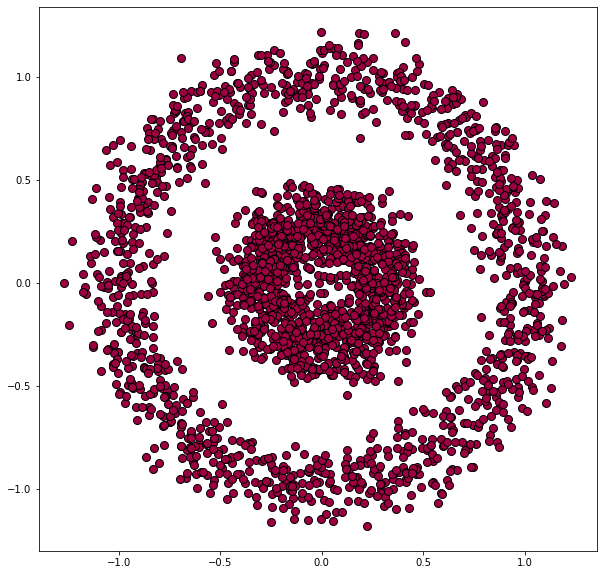

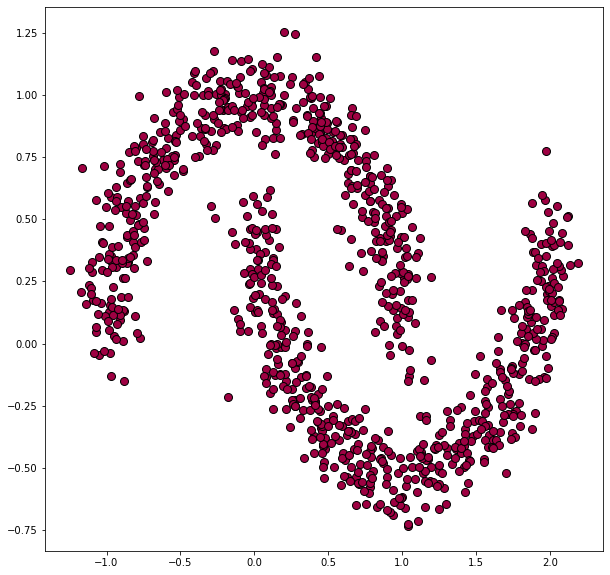

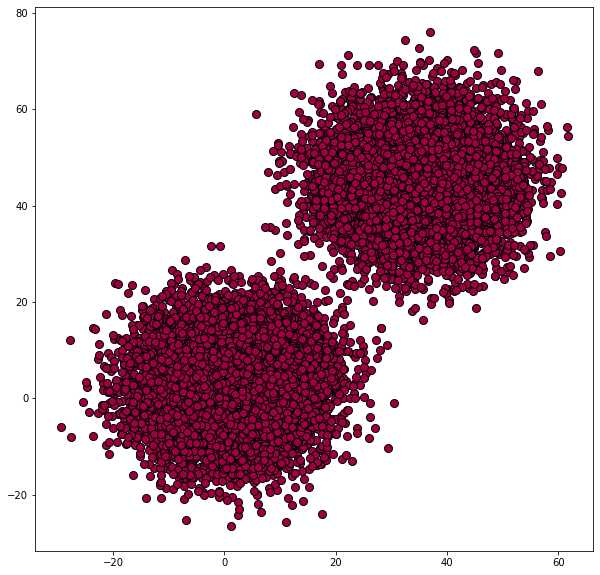

In [13]:
plot_clustering(X_circles, np.zeros(X_circles.shape[0]))
plot_clustering(X_moons, np.zeros(X_moons.shape[0]))
plot_clustering(X_blobs, np.zeros(X_blobs.shape[0]))

In [67]:
# Check where we get stable macro clusters: from 20 to 40+
cluster_formation_matrix(X_circles, [5, 10, 15, 20, 30, 40])

First row: k-values.
Labels compared with cluster 4.
Missing small numbers could not be fit with this clusterings' clusters.
[[   5.   10.   15.   20.   30.   40.]
 [2400. 2400. 2400. 1200. 1200. 1200.]
 [   0.    0.    0. 1200. 1200. 1200.]]


In [60]:
# make a k-means model with k=30
model_circles = KMeans(n_clusters=30).fit(X_circles)

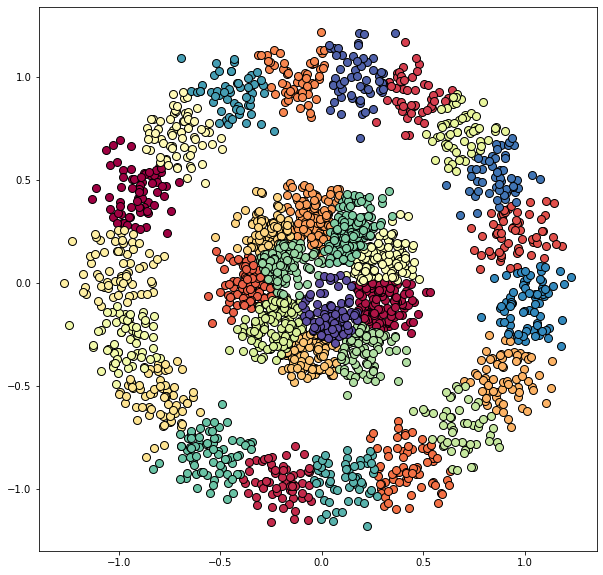

In [61]:
# visual check of the k-means model
plot_clustering(X_circles, model_circles.labels_)

In [62]:
# create a k-meansCD model from that k-means model
model_cd_circles = KMeansCD(model_circles, X_circles).fit()

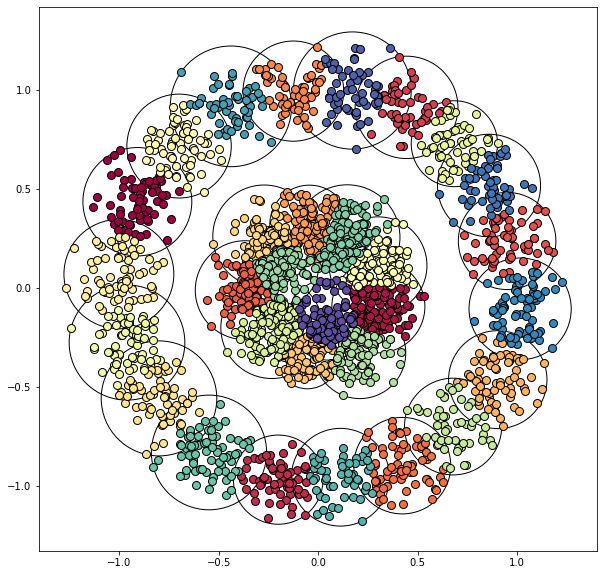

In [63]:
# the original k-means model with the circles from k-meansCD overlayed
plot_clustering_with_circles(X_circles, model_circles.labels_, model_circles.cluster_centers_, 
                             model_cd_circles.radius_matrix_)

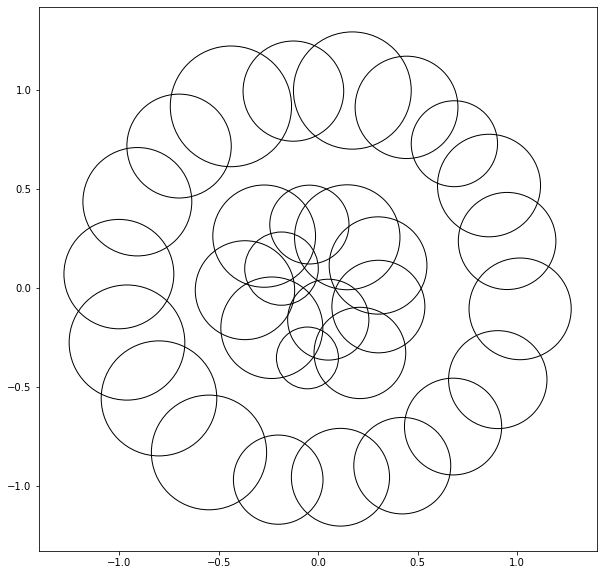

In [64]:
# Only the circles for visibility
plot_clustering_with_circles(X_circles, model_circles.labels_, model_circles.cluster_centers_, 
                             model_cd_circles.radius_matrix_, only_circles=True)

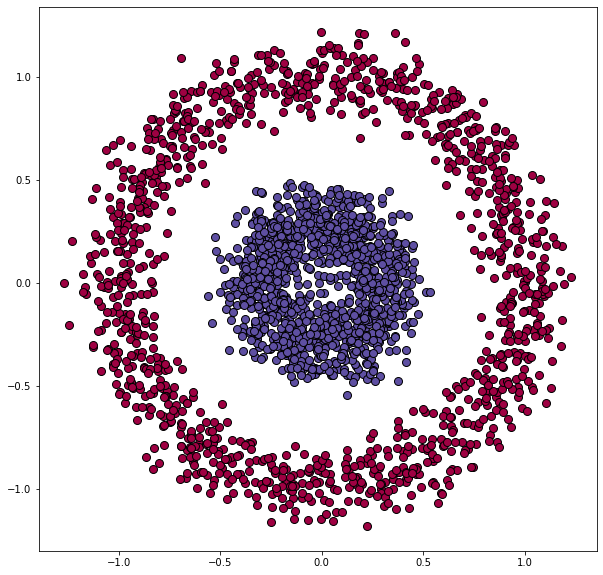

In [66]:
# plot the k-meansCD clustering
plot_clustering(X_circles, model_cd_circles.labels_)

In [68]:
# can be done for all toy data sets above

## 4. Clearly Separable Clustering Data Sets - FCPS (Fundamental Clustering Problem Suite)  <a name="clearlyseparabledatasets"></a>

Datasets from:

https://github.com/gagolews/clustering_benchmarks_v1/tree/master/fcps

### 4.1 FCPS Atom

In [72]:
at_X = np.loadtxt("data/atom.data") # data
at_y = np.loadtxt("data/atom.labels0") # intended clustering

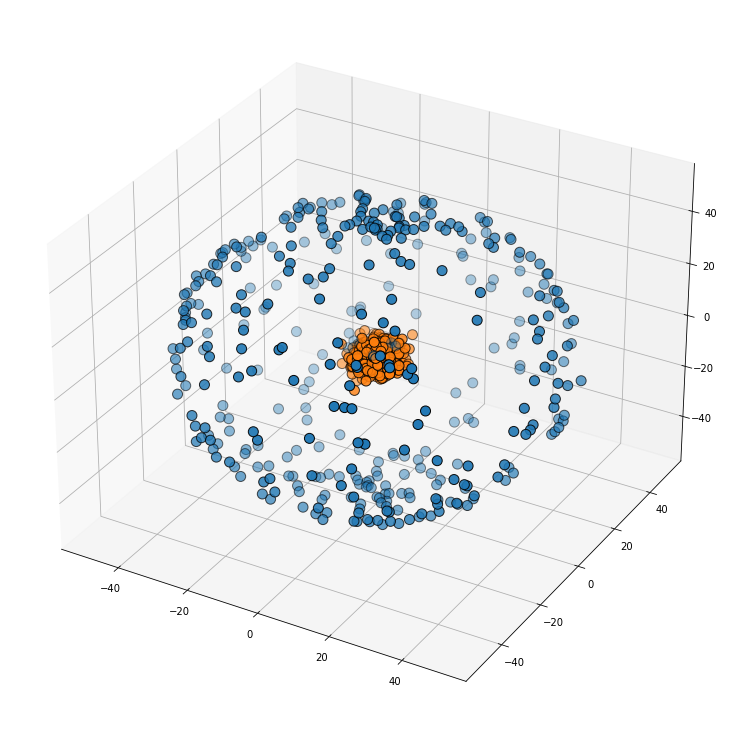

In [73]:
# plot of intended clustering
plot_clustering_3d(at_X, at_y)

In [74]:
# check if there are stable clusters
cluster_formation_matrix(at_X, [5, 10, 15, 20, 30, 40])

First row: k-values.
Labels compared with cluster 3.
Missing small numbers could not be fit with this clusterings' clusters.
[[  5.  10.  15.  20.  30.  40.]
 [800. 800. 400. 400. 400. 400.]
 [  0.   0. 400. 400. 400. 400.]]


In [75]:
# create k-means model
model_atom = KMeans(n_clusters=20).fit(at_X)

In [76]:
# create k-means model with cluster merging and density
new_labels_atom = KMeansCD(model_atom, at_X).fit().labels_

In [77]:
# unify labels
new_labels_atom_un = unify_labels(at_y, new_labels_atom)

In [78]:
# 1.0 means 100% identical
sum(new_labels_atom_un == at_y)/at_y.shape[0]

1.0

### 4.2 FCPS Chainlink

In [81]:
cl_X = np.loadtxt("data/chainlink.data") # data
cl_y = np.loadtxt("data/chainlink.labels0") # intended clustering

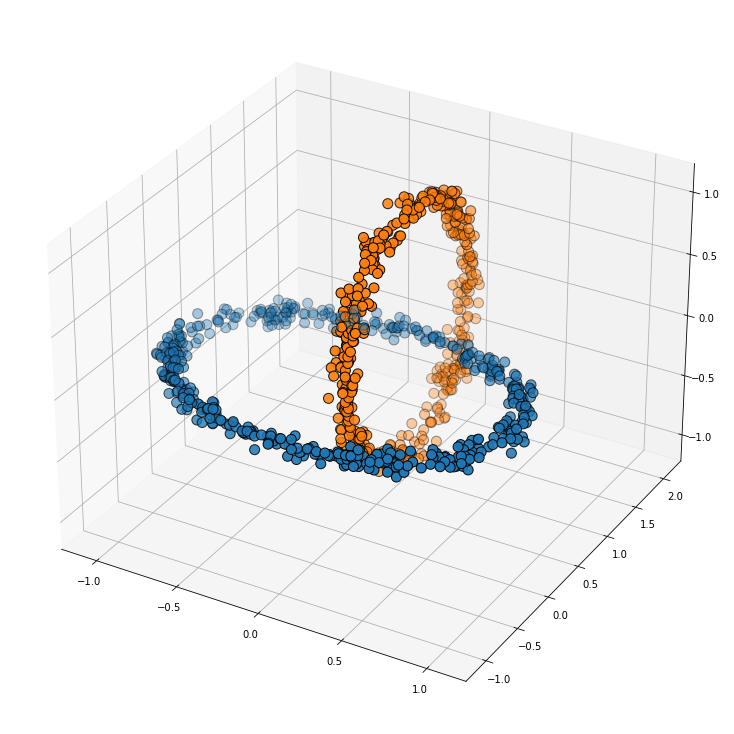

In [82]:
plot_clustering_3d(cl_X, cl_y) # plot intended clustering

In [86]:
# check for stable clusters
cluster_formation_matrix(cl_X, [10, 15, 17, 20, 25, 30])

First row: k-values.
Labels compared with cluster 6.
Missing small numbers could not be fit with this clusterings' clusters.
[[  10.   15.   17.   20.   25.   30.]
 [   0.    0.    0.    0.    0.   41.]
 [   0.    0.    0.    0.   78.   60.]
 [   0.    0.    0.    0.    0.   59.]
 [   0.    0.    0.    0.  130.   87.]
 [   0.    0.  388.    0.  292.  112.]
 [   0.    0.    0.    0.  149.   86.]
 [   0.    0.    0.    0.    0.  103.]
 [1000.  500.  500.  500.  119.  279.]
 [   0.  500.  112.  500.   78.  118.]
 [   0.    0.    0.    0.    0.   16.]
 [   0.    0.    0.    0.    0.   39.]]


In [87]:
# create k-means model
model_chainlink = KMeans(n_clusters=20).fit(cl_X) 

In [89]:
# create k-means model with cluster merging and density
new_labels_chainlink = KMeansCD(model_chainlink, cl_X).fit().labels_

In [90]:
# unify labels
new_labels_chainlink_un = unify_labels(cl_y, new_labels_chainlink)

In [91]:
# 1.0 means 100% identical
sum(new_labels_chainlink_un == cl_y)/cl_y.shape[0]

1.0

### 4.3 FCPS Hepta

In [94]:
h_X = np.loadtxt("data/hepta.data") # data set
h_y = np.loadtxt("data/hepta.labels0") # intended clustering

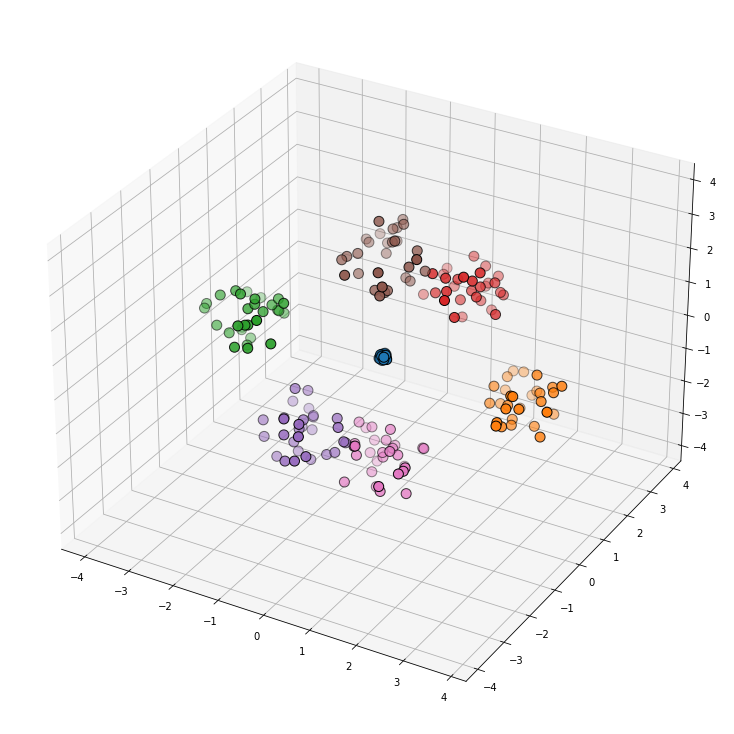

In [95]:
plot_clustering_3d(h_X, h_y) # plot ontended clustering

In [96]:
# check for stable clusters
cluster_formation_matrix(h_X, [5, 10, 15, 20, 30, 40])

First row: k-values.
Labels compared with cluster 6.
Missing small numbers could not be fit with this clusterings' clusters.
[[  5.  10.  15.  20.  30.  40.]
 [  0.   0.   0.   0.   0.   3.]
 [  0.   0.   0.   0.   0.   2.]
 [  0.   0.   0.   0.   0.   2.]
 [  0.   0.   0.   0.   0.   3.]
 [  0.   0.   0.   0.   4.   3.]
 [  0.   0.   0.   0.   0.   5.]
 [  0.   0.   0.   0.   0.   4.]
 [  0.  30.  30.  30.  30.  20.]
 [  0.  30.  30.  30.  30.  30.]
 [  0.  30.  30.  30.  26.  20.]
 [  0.  30.  30.  30.  30.  24.]
 [  0.   0.   0.   0.   0.   4.]
 [  0.  30.  30.  30.  30.  30.]
 [  0.  30.  30.  30.  30.  30.]
 [212.  32.  32.  32.  32.  32.]]


In [97]:
# create k-means model
model_hepta = KMeans(n_clusters=20).fit(h_X)

In [98]:
# create k-means with cluster merging and density model
new_labels_hepta = KMeansCD(model_hepta, h_X).fit().labels_

In [99]:
# unify labels
new_labels_hepta_un = unify_labels(h_y, new_labels_hepta)

In [100]:
# 1.0 means 100% identical
sum(new_labels_hepta_un == h_y)/h_y.shape[0]

1.0

### 4.4 FCPS Lsun

In [102]:
lsun_X = np.loadtxt("data/fcps_lsun.data") # data set
lsun_y = np.loadtxt("data/fcps_lsun.labels0") # intended clustering

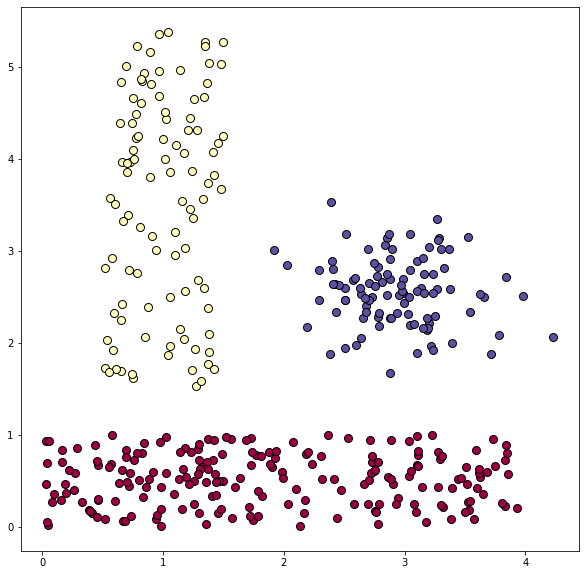

In [103]:
plot_clustering(lsun_X, lsun_y) # plot intended clustering

In [164]:
# check stable clusters
cluster_formation_matrix(lsun_X, [5, 10, 15, 20, 30, 40])

First row: k-values.
Labels compared with cluster 6.
Missing small numbers could not be fit with this clusterings' clusters.
[[  5.  10.  15.  20.  30.  40.]
 [  0.   0.   0.   0.   0.   7.]
 [  0.   0.   0.   0.   0.   8.]
 [  0.   0.   0.   0.   0.   6.]
 [  0.   0.   0.   0.   0.  29.]
 [  0.   0.   0.   0.  21.  12.]
 [  0.   0.   0.   0.   0.  19.]
 [ 60. 100. 100. 100.  79.  48.]
 [  0. 100. 100. 100. 100. 100.]
 [340. 200. 200. 200. 200. 171.]]


In [107]:
# create k-means model
model_lsun = KMeans(n_clusters=20).fit(lsun_X)

In [108]:
# create k-means with cluster merging and density model
new_labels_lsun = KMeansCD(model_lsun, lsun_X).fit().labels_

In [109]:
# unify labels
new_labels_lsun_un = unify_labels(lsun_y, new_labels_lsun)

In [110]:
# 1.0 means 100% identical
sum(new_labels_lsun_un == lsun_y)/lsun_y.shape[0]

1.0

### 4.5 FCPS Target

In [111]:
target_X = np.loadtxt("data/fcps_target.data") # data set
target_y = np.loadtxt("data/fcps_target.labels0") # intended labels

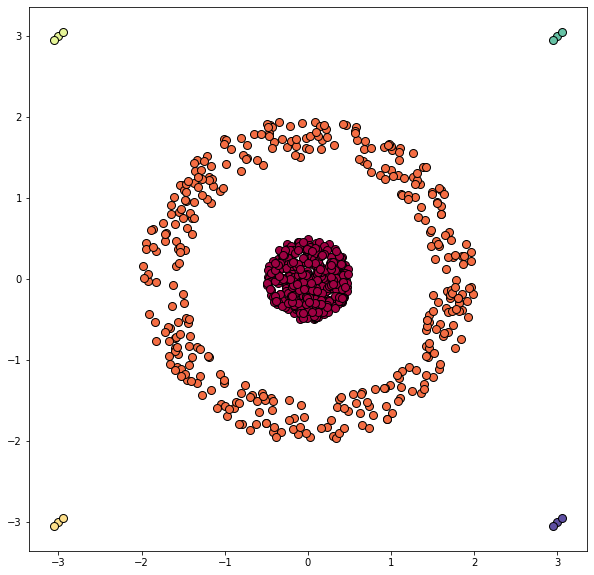

In [112]:
plot_clustering(target_X, target_y) # plot intended clustering

In [113]:
# check stable clusterings 
cluster_formation_matrix(target_X, [10, 14, 15, 16, 17, 18, 19])

First row: k-values.
Labels compared with cluster 3.
Missing small numbers could not be fit with this clusterings' clusters.
[[ 10.  14.  15.  16.  17.  18.  19.]
 [  0.   0.   3.   3.   3.   3.   3.]
 [  0.   3.   3.   3.   3.   3.   3.]
 [  0.   3.   3.   3.   3.   3.   3.]
 [  3.   3.   3.   3.   3.   3.   3.]
 [  0.   0.  48.   0.   0.   0.   0.]
 [  0.   0. 197. 363. 363. 363. 198.]
 [  0.   0. 118.   0.   0.   0. 165.]
 [767. 761. 395. 395. 395. 395. 395.]]


In [114]:
# create k-means model
model_target = KMeans(n_clusters=17).fit(target_X)

In [115]:
# create k-means with cluster merging and density model
new_labels_target = KMeansCD(model_target, target_X).fit().labels_

In [116]:
# unify labels
new_labels_target_un = unify_labels(target_y, new_labels_target)

In [117]:
# 1.0 means 100% identical
sum(new_labels_target_un == target_y)/target_y.shape[0]

1.0

### 4.6 FCPS Tetra

In [119]:
tetra_X = np.loadtxt("data/tetra.data") # data set
tetra_y = np.loadtxt("data/tetra.labels0") # intended labels

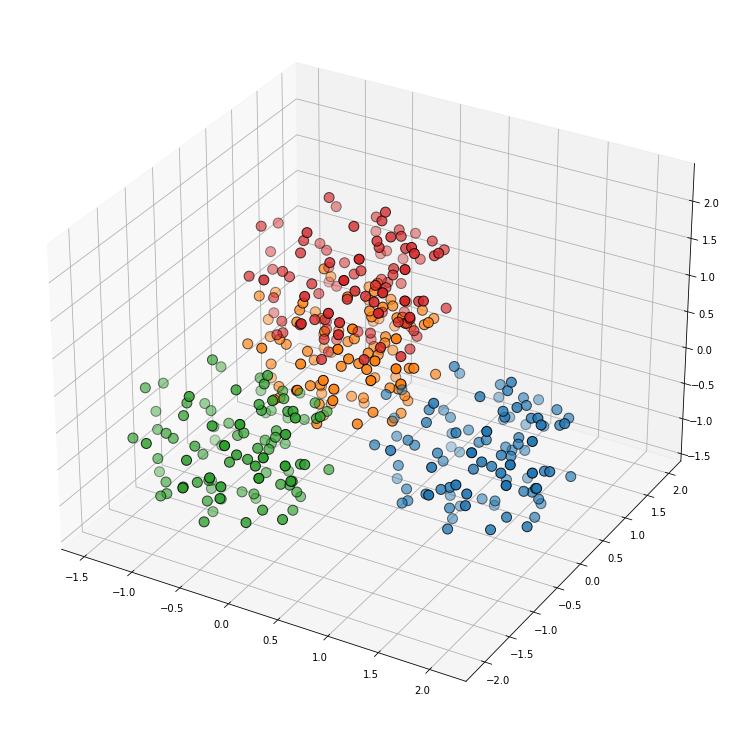

In [120]:
plot_clustering_3d(tetra_X, tetra_y) # plot intended clustering

In [123]:
# check for stable clusters
cluster_formation_matrix(tetra_X, [2, 3, 4, 5, 10])

First row: k-values.
Labels compared with cluster 3.
Missing small numbers could not be fit with this clusterings' clusters.
[[  2.   3.   4.   5.  10.]
 [400. 400. 100. 400. 400.]
 [  0.   0. 100.   0.   0.]
 [  0.   0. 100.   0.   0.]
 [  0.   0. 100.   0.   0.]]


In [124]:
# create k-means model
model_tetra = KMeans(n_clusters=4).fit(tetra_X)

In [127]:
#  create k-means with cluster merging and density model
new_labels_tetra = KMeansCD(model_tetra, tetra_X).fit().labels_

In [128]:
# unify labels
new_labels_tetra_un = unify_labels(tetra_y, new_labels_tetra)

In [129]:
# 1.0 means 100% identical
sum(new_labels_tetra_un == tetra_y)/tetra_y.shape[0]

1.0

### 4.7 FCPS Twodiamonds

In [131]:
diamonds_X = np.loadtxt("data/twodiamonds.data") # data
diamonds_y = np.loadtxt("data/fcps_twodiamonds.labels0") # intended labels

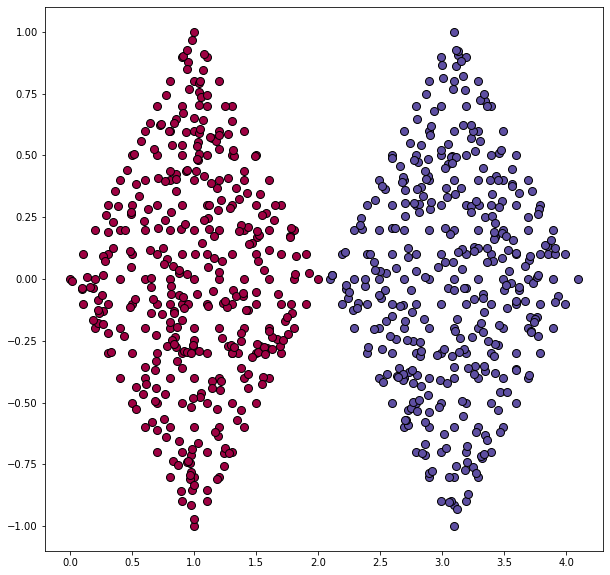

In [132]:
plot_clustering(diamonds_X, diamonds_y) # plot intended clustering

In [139]:
# check stable clusters
cluster_formation_matrix(diamonds_X, [2, 5, 10, 20, 40])

First row: k-values.
Labels compared with cluster 5.
Missing small numbers could not be fit with this clusterings' clusters.
[[  2.   5.  10.  20.  40.]
 [  0.   0.   0.   0.  14.]
 [400.   0. 400. 400. 383.]
 [400. 800. 400. 400. 403.]]


In [140]:
# create k-means model
model_diamonds = KMeans(n_clusters=10).fit(diamonds_X)

In [141]:
# create k-means with cluster merging and density model
new_labels_diamonds = KMeansCD(model_diamonds, diamonds_X).fit().labels_

In [142]:
# unify labels
new_labels_diamonds_un = unify_labels(diamonds_y, new_labels_diamonds)

In [143]:
# 1.0 means 100% identical
sum(new_labels_diamonds_un == diamonds_y)/diamonds_y.shape[0]

1.0

### 4.8 FCPS Wingnut 

In [146]:
wingnut_X = np.loadtxt("data/wingnut.data") # data
wingnut_y = np.loadtxt("data/fcps_wingnut.labels0") # intended labels

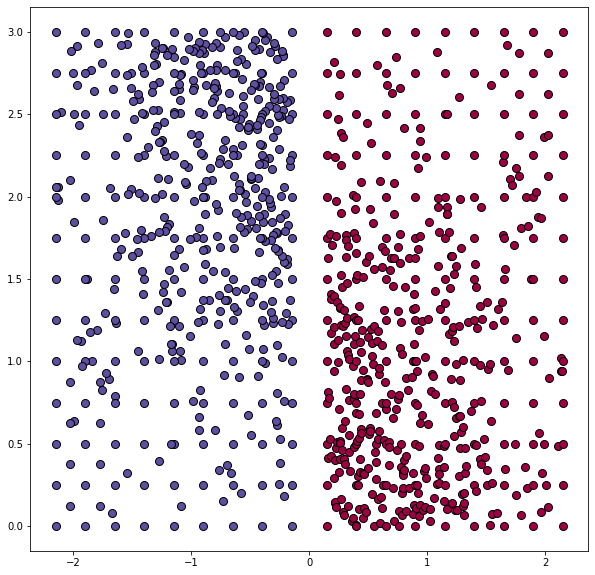

In [147]:
plot_clustering(wingnut_X, wingnut_y) # plot indended clustering

In [149]:
# find stable clusters
cluster_formation_matrix(wingnut_X, [55, 60, 65, 70, 75, 110])

First row: k-values.
Labels compared with cluster 6.
Missing small numbers could not be fit with this clusterings' clusters.
[[  55.   60.   65.   70.   75.  110.]
 [   0.    0.    0.    0.    0.    6.]
 [   0.    0.    0.    0.    0.   10.]
 [   0.    0.    0.    0.    0.   10.]
 [   0.    0.    0.    0.    0.   19.]
 [   0.    0.    0.    0.    0.   49.]
 [   0.    0.    0.    0.    0.    7.]
 [   0.    0.    0.    0.    0.    8.]
 [   0.    0.    0.    0.    0.   11.]
 [   0.    0.    0.    0.    0.   28.]
 [   0.    0.    0.    0.    0.   12.]
 [   0.    0.    0.    0.    0.    3.]
 [1016.  497.  508.  508.  508.  417.]
 [   0.  508.  508.  508.  508.  406.]
 [   0.    0.    0.    0.    0.   30.]]


In [150]:
# create k-means model
model_wingnut = KMeans(n_clusters=70).fit(wingnut_X)

In [151]:
# create k-means with cluster merging and density model
new_labels_wingnut = KMeansCD(model_wingnut, wingnut_X).fit().labels_

In [152]:
# unify labels
new_labels_wingnut_un = unify_labels(wingnut_y, new_labels_wingnut)

In [153]:
# 1.0 means 100% identical
sum(new_labels_wingnut_un == wingnut_y)/wingnut_y.shape[0]

1.0

## 5. Density and Overlap: FCPS, HDBSCAN, CHAMELEON <a name="densityandoverlap"></a>

### 5.1 FCPS Engytime

In [155]:
et_X = np.loadtxt("data/engytime.data") # data set
et_y_orig = np.loadtxt("data/fcps_engytime.labels0") # original labels with overlap (there is another label set)

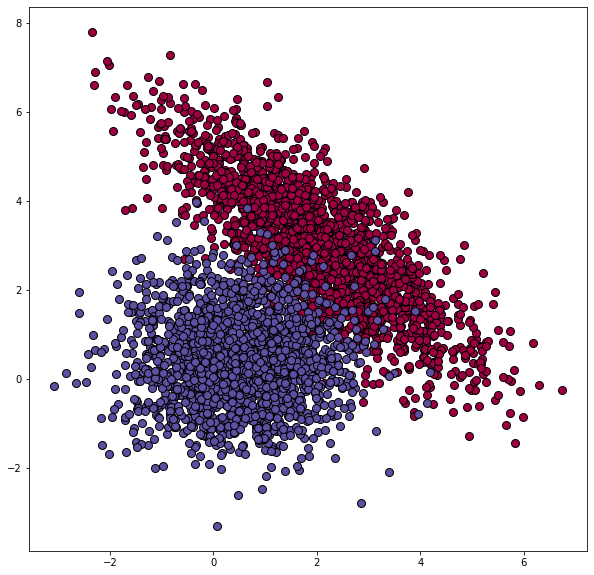

In [156]:
plot_clustering(et_X, et_y_orig) # plot intended clustering

In [167]:
# check ppr for different k
KMeansCD(KMeans(n_clusters=120).fit(et_X), et_X).fit().ppr_

('minppr, meanppr, maxppr:',
 3.996453995447431,
 215.48465001389667,
 692.5811707169377)

In [168]:
# mitPts >= meanppr
cluster_formation_matrix(et_X, [120, 120, 120, 120, 120], minPts=350)

First row: k-values.
Last row outliers.
Labels compared with cluster 1.
Missing small numbers could not be fit with this clusterings' clusters.
[[ 120.  120.  120.  120.  120.]
 [1437. 1389. 1491. 1406. 1468.]
 [1490. 1314. 1174. 1239. 1544.]
 [1169. 1393. 1431. 1451. 1084.]]


In [191]:
# create k-means model
model_engytime = KMeans(n_clusters=120).fit(et_X)

In [192]:
# create k-means with cluster merging and density model
new_labels_engytime = KMeansCD(model_engytime, et_X, minPts=350).fit().labels_

In [193]:
# unify labels
new_labels_engytime_un = unify_labels(et_y_orig, new_labels_engytime)

In [194]:
# 1.0 means 100% identical
sum(new_labels_engytime_un == et_y_orig)/et_y_orig.shape[0]

0.700927734375

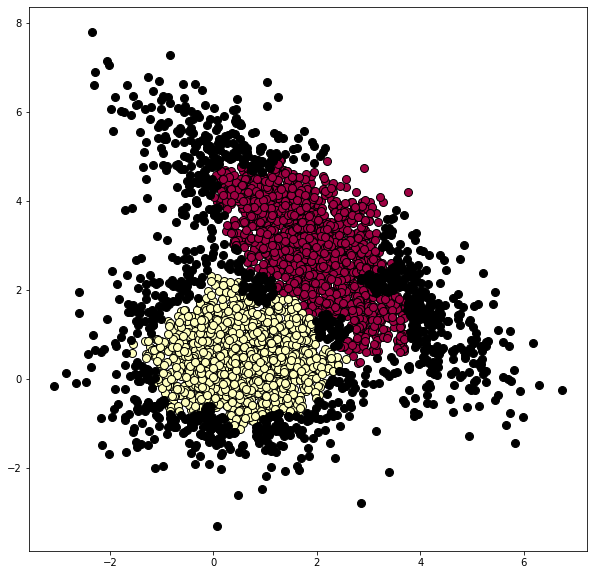

In [195]:
# plot clustering
plot_clustering(et_X, new_labels_engytime_un)

#### Compare to DBSCAN

In [184]:
from sklearn.cluster import DBSCAN

In [185]:
model_dbscan_engytime = DBSCAN(eps=0.3, min_samples=41).fit(et_X)

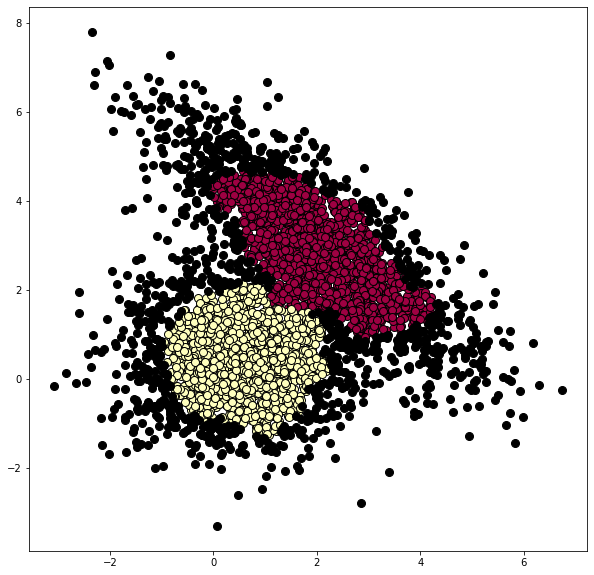

In [186]:
plot_clustering(et_X, model_dbscan_engytime.labels_)

In [188]:
dbscan_engytime_un = unify_labels(et_y_orig, model_dbscan_engytime.labels_)

In [190]:
sum(dbscan_engytime_un == et_y_orig)/et_y_orig.shape[0]

0.692138671875

## 5.2 HDBSCAN Dataset

from https://github.com/gagolews/clustering_benchmarks_v1/blob/master/catalogue/other.md

In [196]:
hdbscan_X = np.loadtxt("data/hdbscan_clusterable.data") # data set
hdbscan_y = np.loadtxt("data/hdbscan_clusterable.labels") # intended clustering

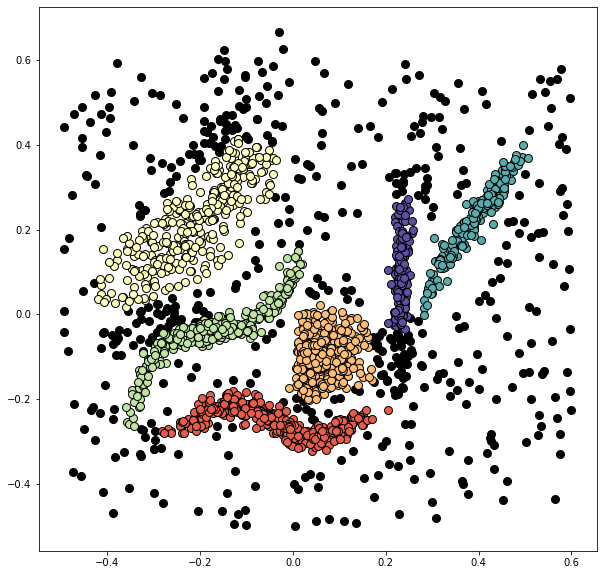

In [197]:
plot_clustering(hdbscan_X, hdbscan_y, outliers=0) # plot intended clustering

In [199]:
# check ppr for different k
KMeansCD(KMeans(n_clusters=150).fit(hdbscan_X), hdbscan_X).fit().ppr_

('minppr, meanppr, maxppr:',
 4.2878169595418685,
 94.65647348823028,
 575.2443791272008)

In [200]:
# mitPts >= meanppr
cluster_formation_matrix(hdbscan_X, [140, 150, 160], minPts=100)

First row: k-values.
Last row outliers.
Labels compared with cluster 2.
Missing small numbers could not be fit with this clusterings' clusters.
[[140. 150. 160.]
 [366. 309. 295.]
 [  0.   2.   0.]
 [  0.   2.   2.]
 [  2.   2.   0.]
 [  0.   5.   0.]
 [  0. 187. 192.]
 [310. 306. 337.]
 [390. 230. 157.]
 [427. 465. 528.]
 [417. 801. 406.]]


In [223]:
model_hdbscan = KMeans(n_clusters=150).fit(hdbscan_X)

In [228]:
new_labels_hdbscan = KMeansCD(model_hdbscan, hdbscan_X, minPts=105).fit().labels_

In [229]:
new_labels_hdbscan_un = unify_labels(hdbscan_y, new_labels_hdbscan, labels1_outlier=0)

In [230]:
# 1.0 means 100% identical
sum(new_labels_hdbscan_un == hdbscan_y)/hdbscan_y.shape[0]

0.913382416630576

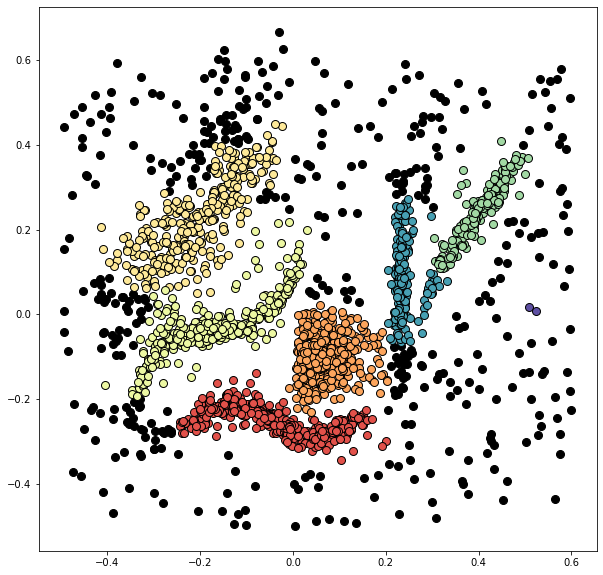

In [231]:
plot_clustering(hdbscan_X, new_labels_hdbscan_un, outliers=0)

## 5.3 Chameleon_t5_8k


data from https://github.com/gagolews/clustering_benchmarks_v1/blob/master/catalogue/other.md

In [233]:
chameleon_t5_8k_X = np.loadtxt("data/chameleon_t5_8k.data") # data
chameleon_t5_8k_y = np.loadtxt("data/chameleon_t5_8k.labels0") # intended labels

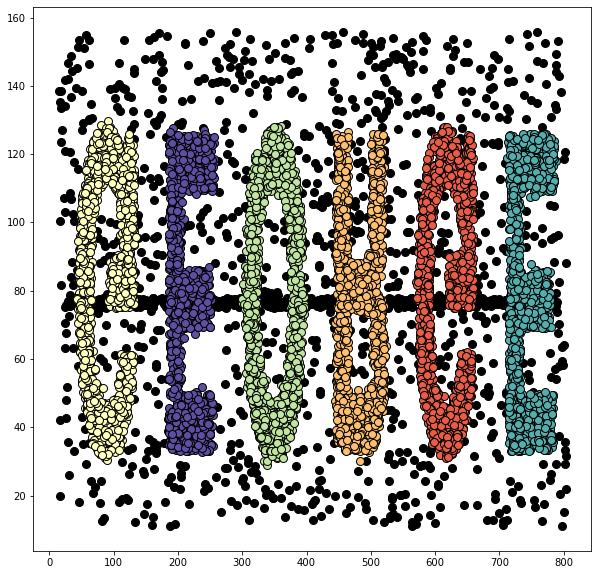

In [234]:
plot_clustering(chameleon_t5_8k_X, chameleon_t5_8k_y, outliers=0) # plot intended clustering

In [235]:
# check ppr for different k
KMeansCD(KMeans(n_clusters=350).fit(chameleon_t5_8k_X), chameleon_t5_8k_X).fit().ppr_

('minppr, meanppr, maxppr:',
 6.8802302400042326,
 130.77389297880111,
 405.69240428208275)

In [238]:
# mitPts >= meanppr
cluster_formation_matrix(hdbscan_X, [250, 300], minPts=150)

First row: k-values.
Last row outliers.
Labels compared with cluster 2.
Missing small numbers could not be fit with this clusterings' clusters.
[[ 250.  300.]
 [   0.    2.]
 [   0.    2.]
 [   0.    4.]
 [   0.    1.]
 [ 146.   57.]
 [   1.    1.]
 [  93.  109.]
 [   0.   25.]
 [ 254.  121.]
 [ 132.   52.]
 [1411. 1935.]]


In [237]:
# create k-means model
model_chameleon_t5_8k = KMeans(n_clusters=300).fit(chameleon_t5_8k_X)

In [239]:
# create k-means with cluster merging and density model
new_labels_chameleon_t5_8k = KMeansCD(model_chameleon_t5_8k, chameleon_t5_8k_X, minPts=150).fit().labels_

In [240]:
# unify labels
new_labels_chameleon_t5_8k_un = unify_labels(chameleon_t5_8k_y, new_labels_chameleon_t5_8k, labels1_outlier=0)

In [241]:
# 1.0 means 100% identical
sum(new_labels_chameleon_t5_8k_un == chameleon_t5_8k_y)/chameleon_t5_8k_y.shape[0]

0.929875

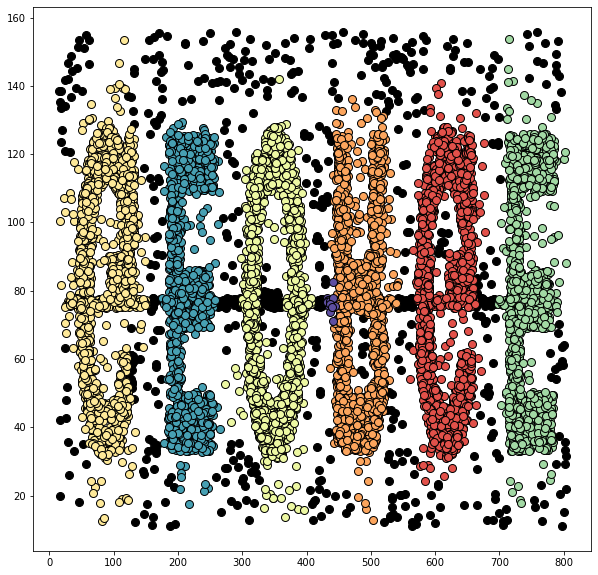

In [242]:
# plot clustering
plot_clustering(chameleon_t5_8k_X, new_labels_chameleon_t5_8k_un, outliers=0)